# Neural Network from Scratch using Numpy

First we will import all the required libraries. <br>
We will train the model on the Iris Dataset and the model will be a very simple 2-layer dataset consisting of 1 Input Layer, 1 Hidden Layer and the Output Layer.

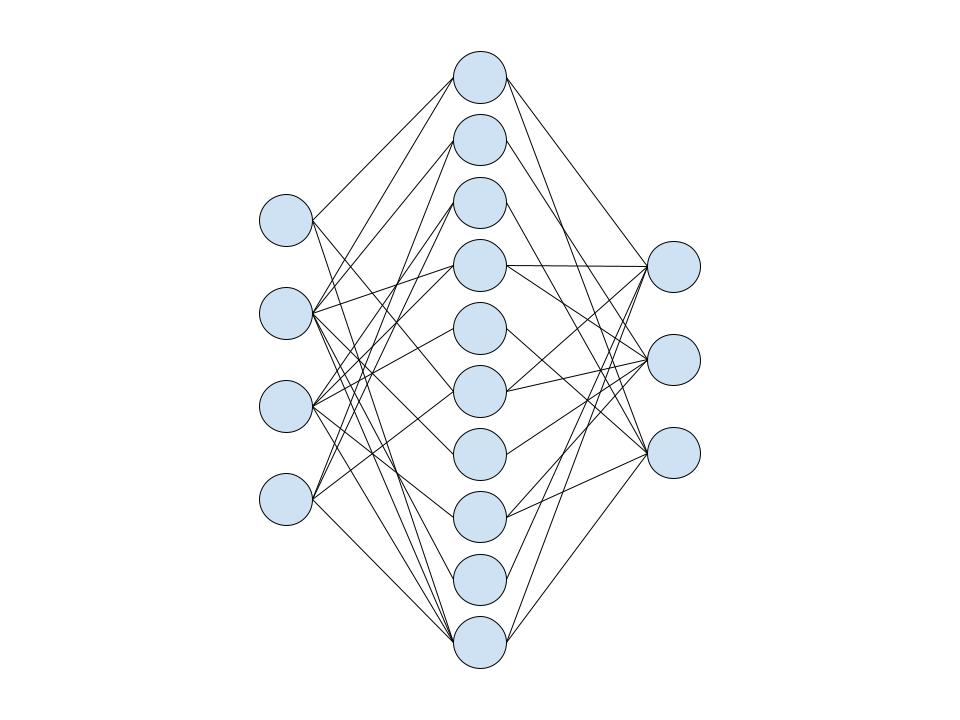

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

This cell contains the Helper Functions used within the notebook. <br>
As this is a Multiclass Classification Function (3 Classes), we will use Softmax Activation at the Output Layer and Cross Entropy Loss as the Error Function that we will minimize using the Neural Network. <br>
For the Hidden Layer we will be using ReLU Activation Function. <br>
All the Functions, there derivatives (for Backpropagation) wrt their input and metric functions are defined here.

In [2]:
### Helper Functions: Activations, Error, Metric Functions

def cross_entropy_loss(y_true, y_pred):
    return -1 * np.sum(y_true * np.log(y_pred))
    

def cross_entropy_and_softmax_derivative(y_true, y_pred):
    return (y_pred - y_true)


def softmax(x):
    xmax = np.max(x, axis=1, keepdims=True)
    softmax = np.exp(x - xmax) / np.sum(np.exp(x - xmax), axis = 1, keepdims = True)
    return softmax


def softmax_derivative(X = None):
    return 1


def relu(x):
    return np.maximum(x, 0)


def relu_derivative(x):
    return (x > 0)


def get_accuracy(y_true, y_pred):

    ground_truth = np.argmax(y_true, axis = 1)
    predictions = np.argmax(y_pred, axis = 1)

    return accuracy_score(ground_truth, predictions)

This Class corresponds to one Layer of the neural network, we need to initialize the weights and bias of the layer, for which we use random initialization using <i>np.random.randn</i>. <br>
We have to pass arguments to the layer, its hyperparameters, telling it how many neurons we are expecting as its input and output. <br>
The Forward and Backward Functions are the core matrix multiplication functions of Neural Networks. The mathematical derivation of these functions is out of the scope of this notebook, but please look at these screenshots to get a deeper understanding of how we arrived at these formulaes. <br>
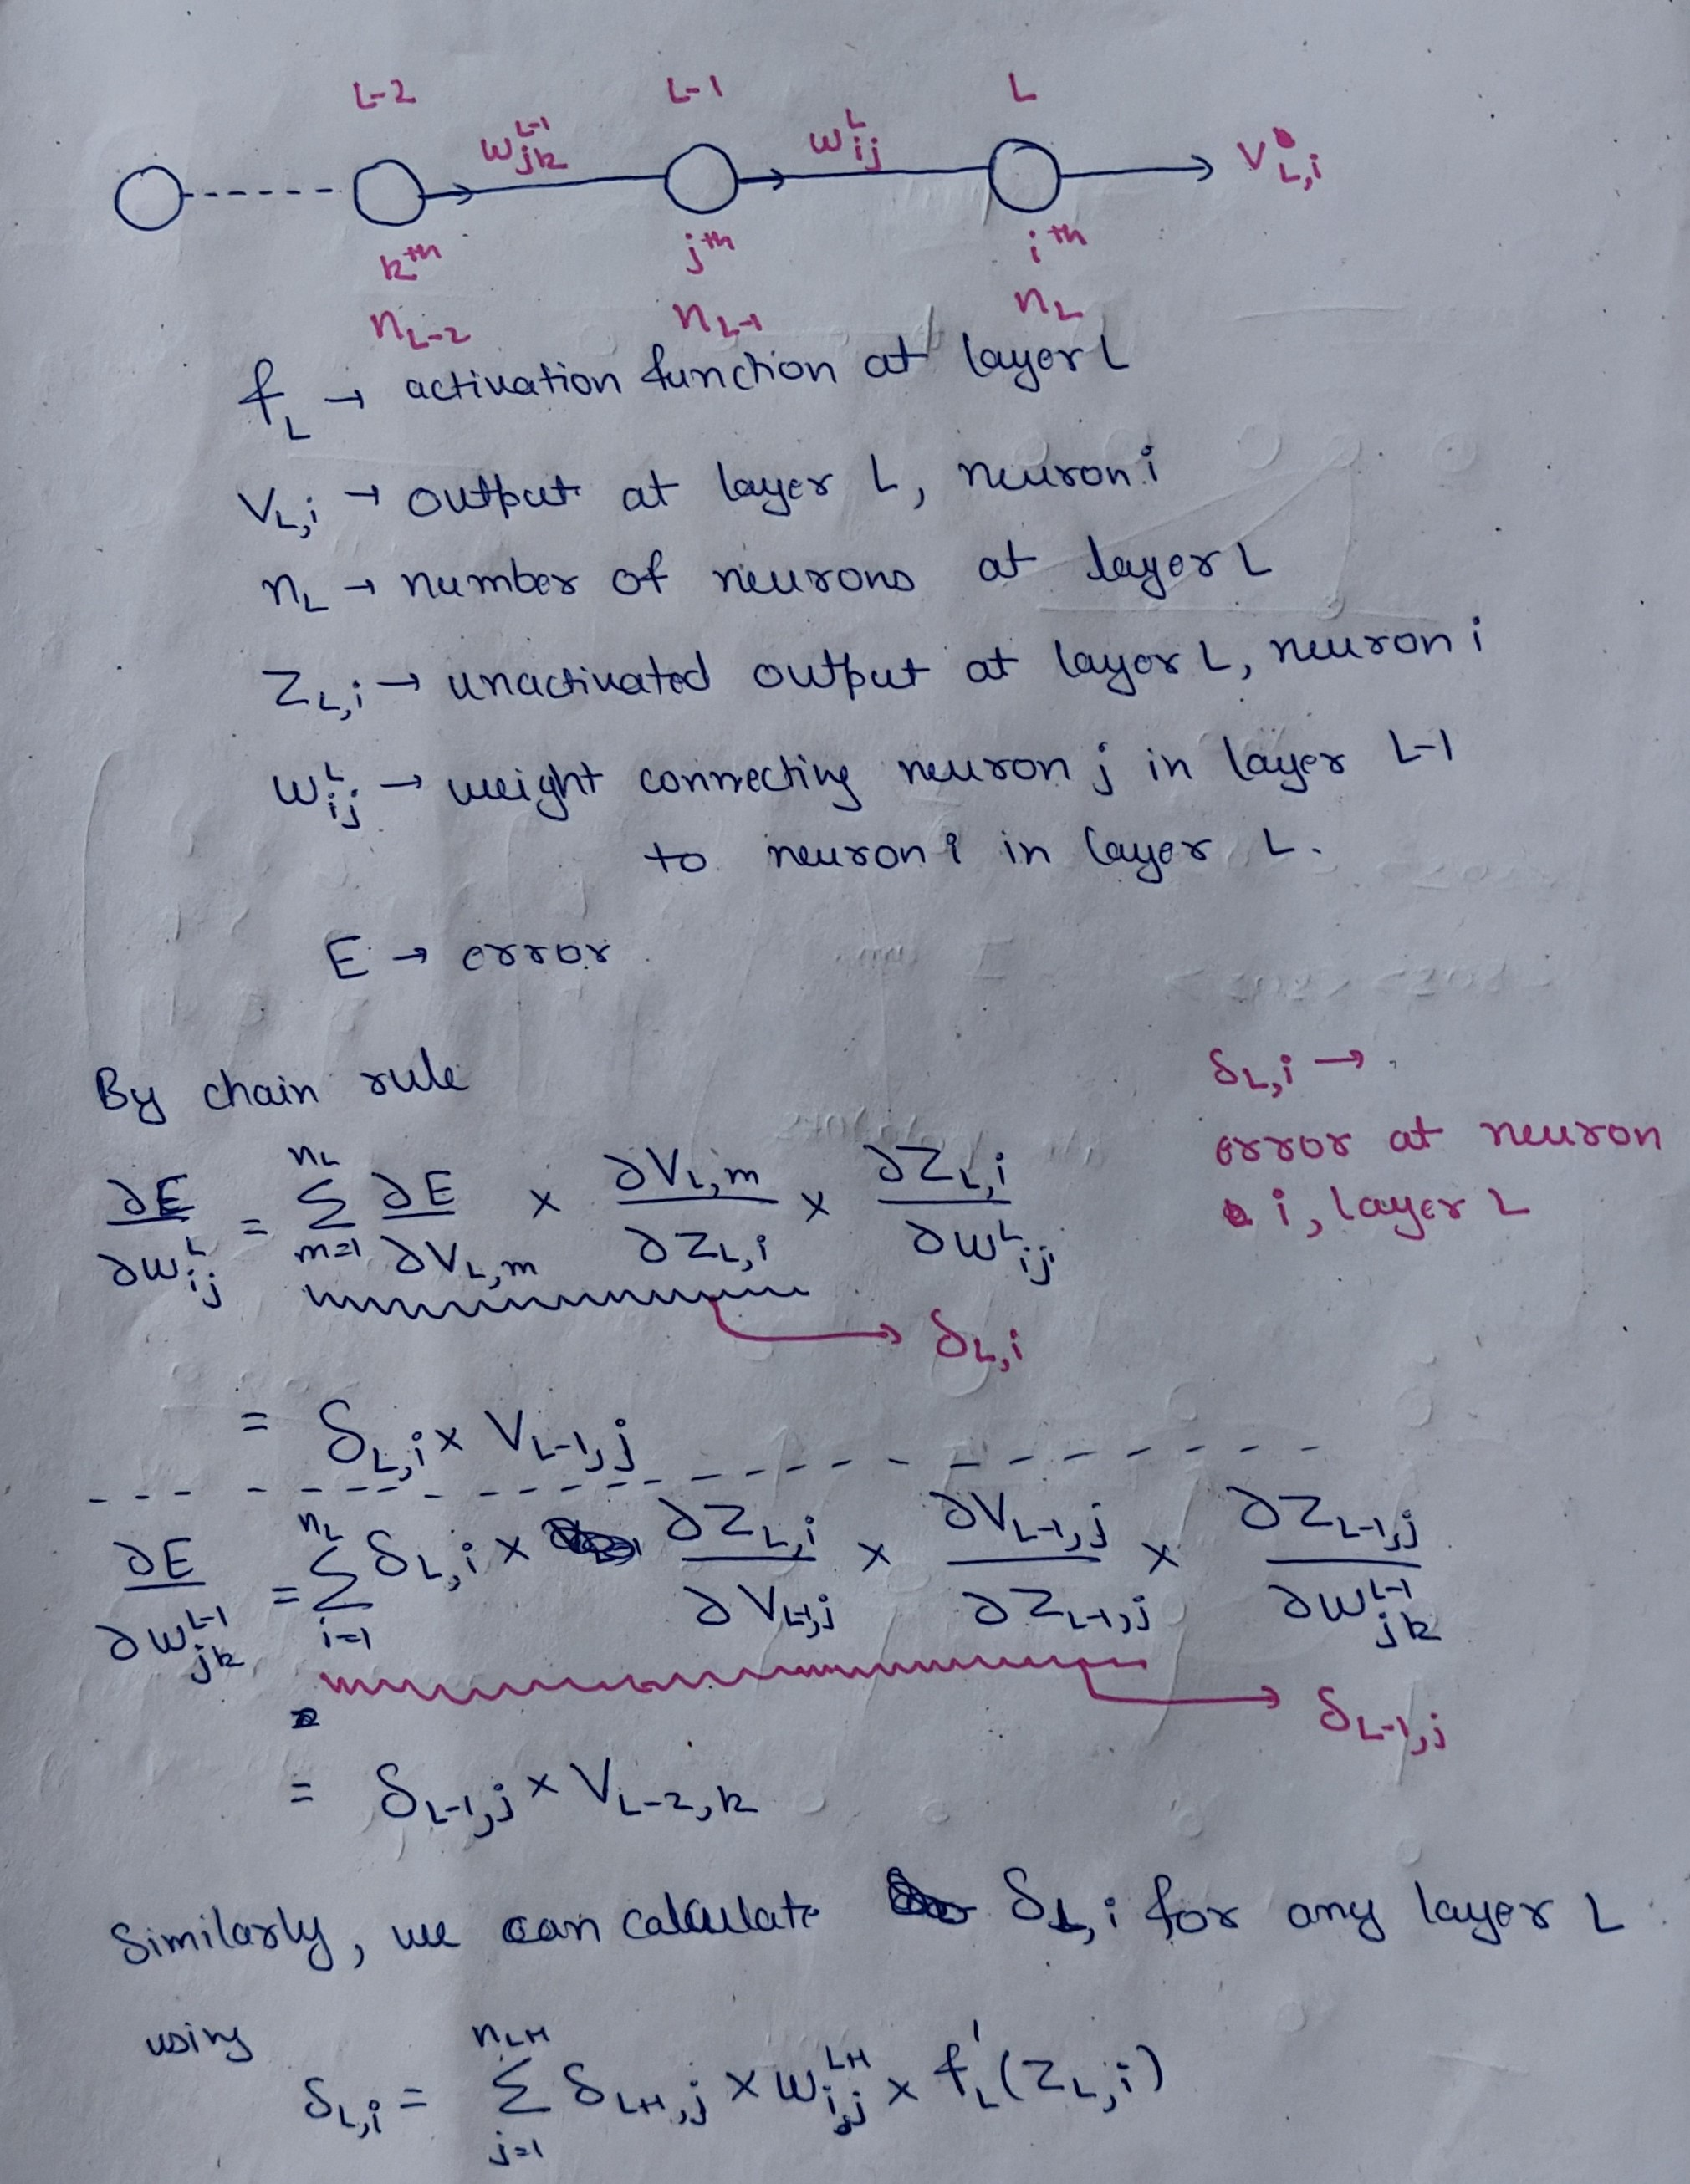
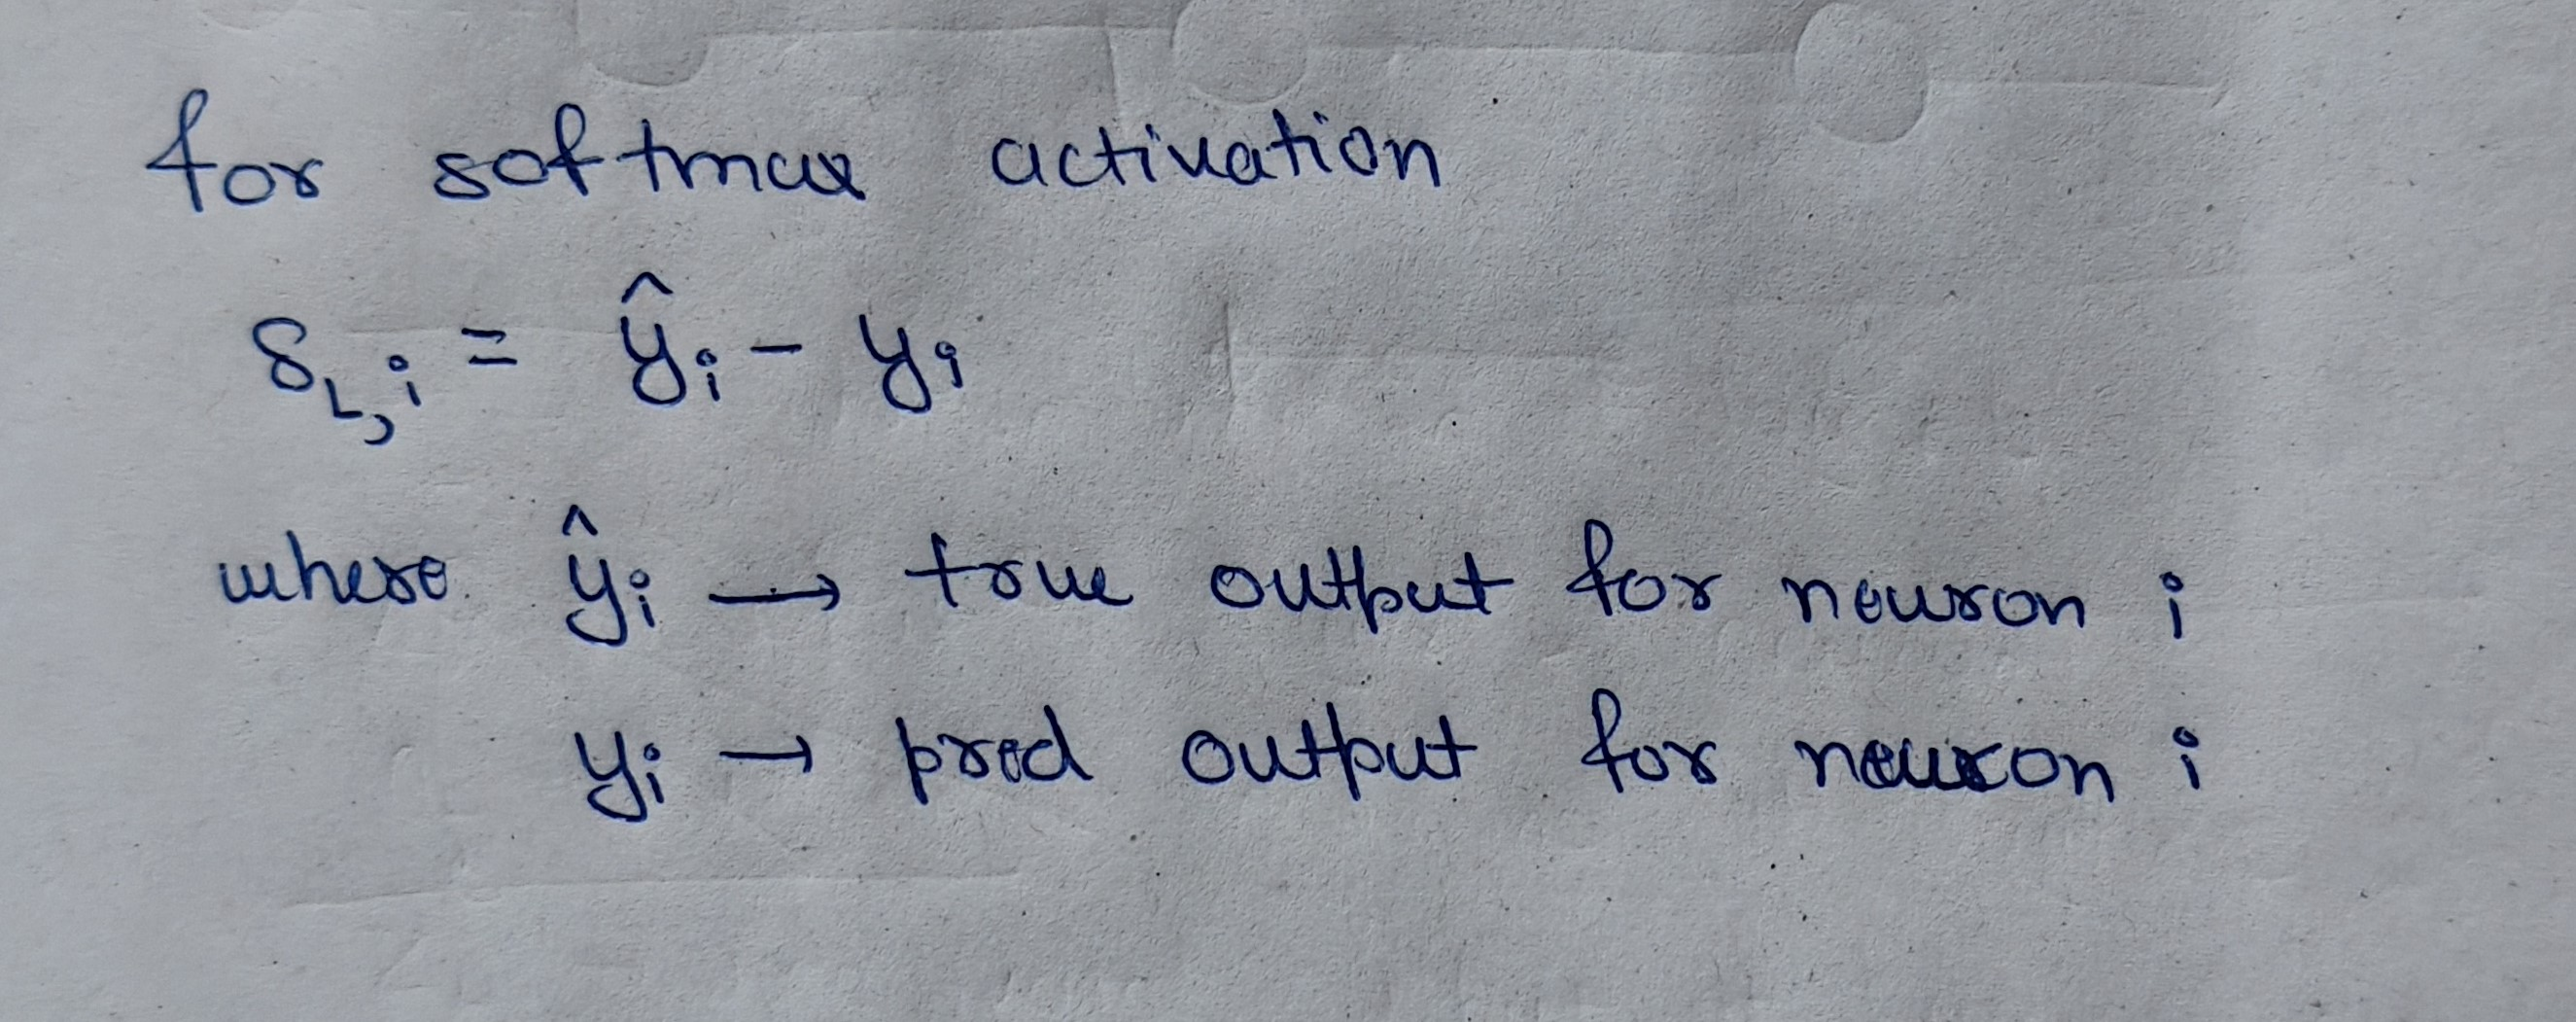

In [3]:
class NeuralLayer():

    def __init__(self, input_size, output_size, act_fn, d_act_fn):
        
        self.weights = np.random.randn(input_size, output_size) ### Shape = (neurons_in, neurons_out)
        self.bias = np.zeros((1, output_size)) ### Shape = (1, neurons_out)
        self.activation_function = act_fn
        self.activation_derivative = d_act_fn
        self.input = None ### Input value to the layer, Shape = (Batch_size, neurons_in)
        self.intermediate_output = None ### Unactivated output by the layer, Shape = (Batch_size, neurons_out)
        self.output = None ### Activation_function(intermediate_output), Shape = (Batch_size, neurons_out)

    def forward(self, X):
        
        self.input = X
        self.intermediate_output = np.matmul(X, self.weights) + self.bias
        self.output = self.activation_function(self.intermediate_output)
        
        return self.output

    def backward(self, error_derivative, learning_rate):

        loss_current_layer = np.multiply(error_derivative, self.activation_derivative(self.intermediate_output)) ### Shape = (Batch_size, neurons_out)
        dweights = np.matmul(self.input.T, loss_current_layer) ### Shape = (neurons_in, Batch_size) x (Batch_size, neurons_out) = (neurons_in, neurons_out)
        dbias = np.sum(loss_current_layer, axis = 0, keepdims = True) ### Shape = (1, neurons_out)
        loss_previous_layer = np.matmul(loss_current_layer, self.weights.T) ### Shape = (Batch_size, neurons_out) x (neurons_out, neurons_in) = (Batch_size, neurons_in)
        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias
        
        return loss_previous_layer

This class corresponds to the entire Neural Network ie the chain of the Neural Network Layers. It takes the input its argument and feeds it through all of the NN Layers to arrive at the output. Then it calculates the error and backpropagates it through the layers to update Weight and Bias params.

In [4]:
class NeuralNetwork():

    def __init__(self):
        
        self.layers = [] ### Contains All Layers within the network
        self.input = None ### Raw input to the Network
        self.output = None ### Output by the Network
        

    def add(self, layer): ### Function that adds a layer to the network
        self.layers.append(layer)
        

    def feed_forward(self, X):

        self.input = X
        for i in range(0, len(self.layers)):
            X = self.layers[i].forward(X) ### Activation(Weights * Input + Bias)
        self.output = X
        
        return self.output
        

    def backward_propagation(self, error_derivative, learning_rate):

        for i in range(len(self.layers) - 1, -1, -1):
            error_derivative = self.layers[i].backward(error_derivative, learning_rate) ### Shape = (Batch_size, n_classes)
            

    def fit(self, X, y, loss_fn, loss_derivative_fn, learning_rate):
        
        self.feed_forward(X)
        error = loss_fn(y, self.output)
        error_derivative = loss_derivative_fn(y, self.output)
        self.backward_propagation(error_derivative, learning_rate)

        return error

    def evaluate(self, X, y, loss_fn):
        
        self.feed_forward(X)
        error = loss_fn(y, self.output)

        return error

In [5]:
### Data Processing

iris_data = pd.read_csv('Iris.csv')

X = iris_data.iloc[:, 1:5].values
y = iris_data.loc[:, ['Species']].values

X_train, X_val, y_train_cat, y_val_cat = train_test_split(X, y, test_size = 0.2)

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cat).toarray()
y_val = enc.transform(y_val_cat).toarray()

ntrain = X_train.shape[0]
nval = X_val.shape[0]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(120, 4) (30, 4) (120, 3) (30, 3)


In [6]:
### NN Initialisation and Layers addition

classifier = NeuralNetwork()

classifier.add(NeuralLayer(4, 10, relu, relu_derivative))
classifier.add(NeuralLayer(10, 3, softmax, softmax_derivative))

In [7]:
### Training and Validation

train_loss_values = []
val_loss_values = []

train_accuracy_values = []
val_accuracy_values = []

nepochs = 50

for epoch in range(0, nepochs):
    train_loss = classifier.fit(X_train, y_train, cross_entropy_loss, cross_entropy_and_softmax_derivative, 0.0001)
    val_loss = classifier.evaluate(X_val, y_val, cross_entropy_loss)

    y_train_pred = classifier.feed_forward(X_train)
    y_val_pred = classifier.feed_forward(X_val)

    train_accuracy = get_accuracy(y_train, y_train_pred)
    val_accuracy = get_accuracy(y_val, y_val_pred)

    train_loss_values.append(train_loss / ntrain)
    val_loss_values.append(val_loss / nval)

    train_accuracy_values.append(train_accuracy)
    val_accuracy_values.append(val_accuracy)

    if((epoch + 1) % 10 == 0):
        print('Epoch:', epoch+1)
        print('Train Loss:', train_loss / ntrain, '||', 'Accuracy:', train_accuracy)
        print('Val Loss:', val_loss / nval, '||', 'Accuracy', val_accuracy)
        print(' ========= \n')

Epoch: 10
Train Loss: 0.4178317601136094 || Accuracy: 0.9
Val Loss: 0.4231217615601327 || Accuracy 0.9

Epoch: 20
Train Loss: 0.37944220838362824 || Accuracy: 0.9
Val Loss: 0.3831756115844211 || Accuracy 0.8666666666666667

Epoch: 30
Train Loss: 0.35498991888957837 || Accuracy: 0.9
Val Loss: 0.35695940507287155 || Accuracy 0.8666666666666667

Epoch: 40
Train Loss: 0.338641514797351 || Accuracy: 0.9083333333333333
Val Loss: 0.33817754531211797 || Accuracy 0.8666666666666667

Epoch: 50
Train Loss: 0.3273482480908649 || Accuracy: 0.9083333333333333
Val Loss: 0.32336308450932894 || Accuracy 0.8666666666666667



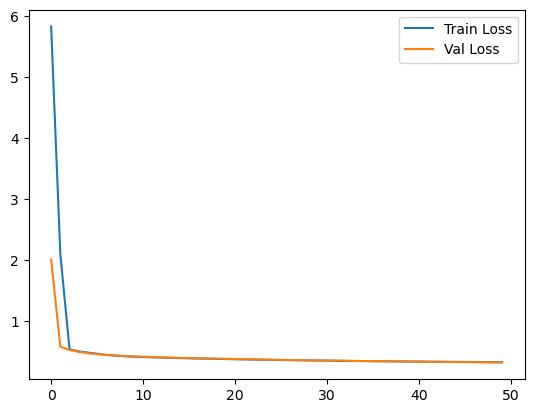

In [8]:
plt.plot(train_loss_values, label = 'Train Loss')
plt.plot(val_loss_values, label = 'Val Loss')
plt.legend()
plt.show()